In [1]:
import numpy as np
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from IPython import display

from scipy.spatial.transform import Rotation as R

import math
from copy import copy
import glob

import random
from scipy.stats import kendalltau

In [2]:
actions = np.load('actions.npy')
ims = np.load('ims.npy')

In [3]:
K = np.max(actions)+1

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
# Set up pytorch dataloader
class Sampler(Dataset):
    
    def __init__(self, ims, actions, K=6):
        
        self.ims = torch.FloatTensor(ims.astype('float'))/6
        self.actions = torch.FloatTensor(actions.astype('float'))
        self.K = K
        
        
    def __len__(self):
        
        return self.ims.shape[0]
    
    def __getitem__(self, index):
        
        im = self.ims[index,:,:,:]
        actions = self.actions[index,:]
        return im, actions, torch.FloatTensor(np.arange(self.K).astype('float'))

In [6]:
dataset = Sampler(np.swapaxes(np.stack(ims),1,3),actions,K)

train_dataset,test_dataset = torch.utils.data.random_split(dataset, [120,120])

In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class SinkhornNet(nn.Module):

    def __init__(self, latent_dim=16, image_channels=3, K=6, max_K=7, n_samples=5, noise_factor=1.0, temp=1.0, n_iters=20):
        super(SinkhornNet, self).__init__()
        
        self.encoder = nn.Sequential(
            Flatten(),
            nn.Linear(27, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        
        # Sinkhorn params
        self.latent_dim = latent_dim
        self.K = K
        self.max_K = max_K
        self.n_samples = n_samples
        self.noise_factor = noise_factor
        self.temp = temp
        self.n_iters = n_iters
        
        self.criterion = nn.MSELoss()
        
        self.sinknet = nn.Sequential(nn.Linear(self.latent_dim, self.latent_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.latent_dim, K*K))
        
    def permute(self,seq,P):
        
        return torch.matmul(P,seq)
    
    def predict_P(self,im):
        
        latent = self.encoder(im)
        log_alpha = self.sinknet(latent)
        log_alpha = log_alpha.reshape(-1, self.K, self.K)
         
        soft_perms_inf, log_alpha_w_noise = self.gumbel_sinkhorn(log_alpha)
        
        P = self.inv_soft_pers_flattened(soft_perms_inf,self.K)
        return P
    
    def forward(self, seq, im):
        
        latent = self.encoder(im)
        log_alpha = self.sinknet(latent)
        log_alpha = log_alpha.reshape(-1, self.K, self.K)
         
        soft_perms_inf, log_alpha_w_noise = self.gumbel_sinkhorn(log_alpha)
        
        P = self.inv_soft_pers_flattened(soft_perms_inf,self.K)
        
        seq_tiled = seq.repeat(self.n_samples, 1)
        
        ordered  = self.permute(torch.unsqueeze(seq_tiled,dim=-1),P)
        
        return ordered
    
    def loss(self, seq, im, seq_gt):
        
        seq_pred = self.forward(seq_gt,im)
        seq_pred = torch.squeeze(seq_pred)
        
        recon_loss = self.criterion(seq_pred[:,0:self.max_K],seq.repeat(self.n_samples, 1))
         
        return recon_loss, seq_pred
    
    def inv_soft_pers_flattened(self,soft_perms_inf,n_numbers):
        inv_soft_perms = torch.transpose(soft_perms_inf, 2, 3)
        inv_soft_perms = torch.transpose(inv_soft_perms, 0, 1)

        inv_soft_perms_flat = inv_soft_perms.view(-1, n_numbers, n_numbers)
        return inv_soft_perms_flat
    
    def sample_gumbel(self, shape, eps=1e-20):
        U = torch.rand(shape).float()
        return -torch.log(eps - torch.log(U + eps))
    
    def gumbel_sinkhorn(self,log_alpha):
        
        n = log_alpha.size()[1]
        log_alpha = log_alpha.view(-1, n, n)
        batch_size = log_alpha.size()[0]

        log_alpha_w_noise = log_alpha.repeat(self.n_samples, 1, 1)

        if self.noise_factor == 0:
            noise = 0.0
        else:
            noise = self.sample_gumbel([self.n_samples*batch_size, n, n])*self.noise_factor

        log_alpha_w_noise = log_alpha_w_noise + noise
        log_alpha_w_noise = log_alpha_w_noise / self.temp

        my_log_alpha_w_noise = log_alpha_w_noise.clone()

        sink = self.sinkhorn(my_log_alpha_w_noise)

        sink = sink.view(self.n_samples, batch_size, n, n)
        sink = torch.transpose(sink, 1, 0)
        log_alpha_w_noise = log_alpha_w_noise.view(self.n_samples, batch_size, n, n)
        log_alpha_w_noise = torch.transpose(log_alpha_w_noise, 1, 0)

        return sink, log_alpha_w_noise
    
    def sinkhorn(self,log_alpha, n_iters = 20):
   
        n = log_alpha.size()[1]
        log_alpha = log_alpha.view(-1, n, n)

        for i in range(n_iters):
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=2, keepdim=True)).view(-1, n, 1)
            log_alpha = log_alpha - (torch.logsumexp(log_alpha, dim=1, keepdim=True)).view(-1, 1, n)
        return torch.exp(log_alpha)


In [9]:
sn = SinkhornNet(latent_dim=128, image_channels=3, K=K,max_K=7)
optimizer = torch.optim.Adam(sn.parameters(), lr=3e-4)
n_epochs = 500
losses = []

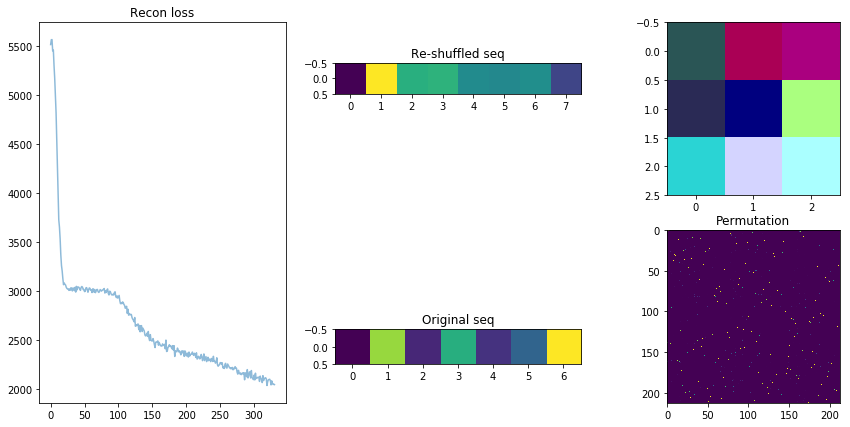

In [ ]:
plt.figure(figsize=(15,7))

for j in range(n_epochs):
    
    batch_losses = []
    for im, seq, seq_order in train_loader:
    
        loss, seq_pred = sn.loss(seq, im, seq_order)
        
        batch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    losses.append(np.mean(batch_losses))
    
    plt.clf()
    plt.cla()
    plt.subplot(1,3,1)
    plt.plot(losses,alpha=0.5)
    plt.title('Recon loss')

    plt.subplot(2,3,6)
    P = sn.predict_P(im)
    plt.imshow(P[0,:,:].detach().numpy())
    plt.title('Permutation')
    
    plt.subplot(3,3,2)
    plt.imshow(seq_pred[0,0:8].detach().numpy().reshape(1,-1))
    plt.title('Re-shuffled seq')
    
    plt.subplot(3,3,8)
    plt.imshow(seq[0,:].detach().numpy().reshape(1,-1))
    plt.title('Original seq')
    
    plt.subplot(2,3,3)
    plt.imshow(np.swapaxes(im[0,:,:,:].detach().numpy(),0,2))
    
        
    display.clear_output(wait=True)
    display.display(plt.gcf())
    